Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")           ## Suppress all warnings

In [23]:
# ## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [24]:
##root_dir = pathlib.Path('C:/02 Srikanth/15 Upgrad/06 Deep Learning/CNN Cancer assignment/Skin_cancer_ISIC')
root_dir = pathlib.Path('Skin_cancer_ISIC')
data_dir_train = root_dir / 'Train'
data_dir_test = root_dir / 'Test'

# Function to count the number of JPG images in a directory
def count_jpg_images(directory):
    count = 0
    for subdir in directory.iterdir():
        count += len(list(subdir.glob('*.jpg')))
    return count

# Count the number of JPG images in the train and test directories
image_count_train = count_jpg_images(data_dir_train)
image_count_test = count_jpg_images(data_dir_test)

print("Total number of JPG images in train folder:", image_count_train)
print("Total number of JPG images in test folder:", image_count_test)

Total number of JPG images in train folder: 2239
Total number of JPG images in test folder: 118


### Load using keras.preprocessing --- Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset - Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


##### seed=123 ensures that the shuffling process produces the same random order of files each time
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualize the data - Todo, create a code to visualize one instance of all the nine classes present in the dataset

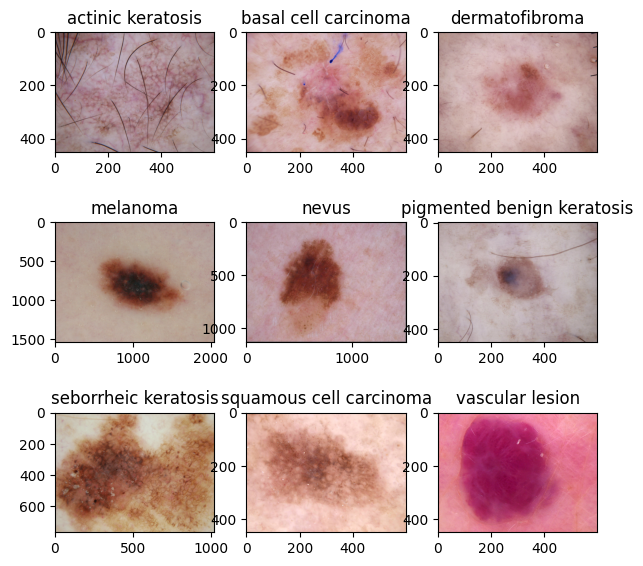

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as img

plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.
`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

**My Notes**
*   putting padding = 'Same' to maintain same spatial dimensions as the input image.
*   when padding='same': If the stride of the convolution operation is 1, the output size will be the same as the input size.
*   If the stride is greater than 1, the output size will be adjusted accordingly to maintain the spatial dimensions as closely as possible to the input size.

In [31]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.30))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


**My Notes**
1. *First Conv2D layer (32 filters):*
Parameters: (5 * 5 * 3 + 1) * 32 = 2432, each with a kernel size of (5,5), and the input shape is (180,180,3)

2. *Second Conv2D layer (32 filters):*
Parameters: (5 * 5 * 32 + 1) * 32 = 25632, and the input shape is the same as the output shape of the previous layer.

3. *Third Conv2D layer (32 filters):*
Parameters: (5 * 5 * 32 + 1) * 32 = 25632, and the input shape is the same as the output shape of the previous layer.

4. *Fourth Conv2D layer (32 filters):*
Parameters: (5 * 5 * 32 + 1) * 32 = 25632, and the input shape is the same as the output shape of the previous layer.

5. *Dropout layer:*
The dropout layer does not have any trainable parameters, so 0 parameters.

6. *Flatten layer:*
The flatten layer does not have any trainable parameters, so 0 parameters.

7. *Dense layer* (3872 input neurons and 9 output neurons)
Parameters: (3872 + 1) * 9 = 34857

8. *Total trainable parameters*: 2432 + 25632 + 25632 + 25632 + 34857 = 139,817


### Compile the model - Choose an appropirate optimiser and loss function for model training

##### Being 9 classes defined, this is categorical model example and hence using this specific loss function

In [32]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Train the model
#### **My notes** -- changed the epochs to 30

In [34]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


56/56 [==============================] - 40s 645ms/step - loss: 2.0655 - accuracy: 0.1747 - val_loss: 2.0495 - val_accuracy: 0.2103
Epoch 2/30
56/56 [==============================] - 40s 723ms/step - loss: 2.0037 - accuracy: 0.2271 - val_loss: 1.9616 - val_accuracy: 0.2148
Epoch 3/30
56/56 [==============================] - 44s 791ms/step - loss: 1.9367 - accuracy: 0.2662 - val_loss: 1.9115 - val_accuracy: 0.2550
Epoch 4/30
56/56 [==============================] - 45s 812ms/step - loss: 1.8703 - accuracy: 0.3019 - val_loss: 1.8333 - val_accuracy: 0.3266
Epoch 5/30
56/56 [==============================] - 47s 847ms/step - loss: 1.7789 - accuracy: 0.3599 - val_loss: 1.6681 - val_accuracy: 0.4094
Epoch 6/30
56/56 [==============================] - 48s 865ms/step - loss: 1.6792 - accuracy: 0.3867 - val_loss: 1.6559 - val_accuracy: 0.4094
Epoch 7/30
56/56 [==============================] - 51s 912ms/step - loss: 1.5867 - accuracy: 0.4336 - val_loss: 1.6200 - val_accuracy: 0.39

#### It is clear that validation accuracy is less than model accuracy, a case of overfitting 

### Visualizing training results

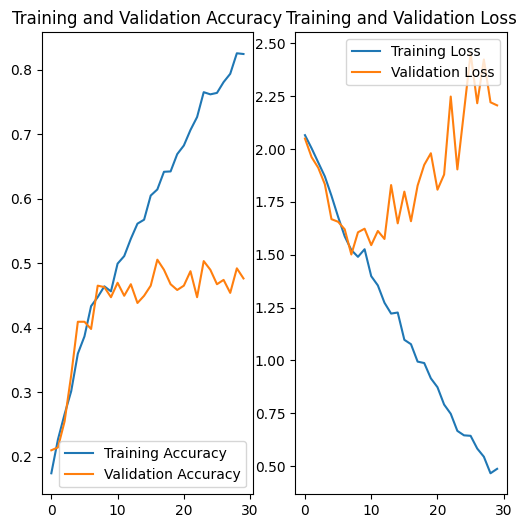

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**My Notes**


The training accuracy is much higher than the validation accuracy, and the training loss is much lower than the validation loss, it indicates overfitting. In this case, the model has learned to fit the training data too well, but it doesn't generalize well to unseen data.
##### Hence applying data augumentation strategy

In [37]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit,
# choose an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

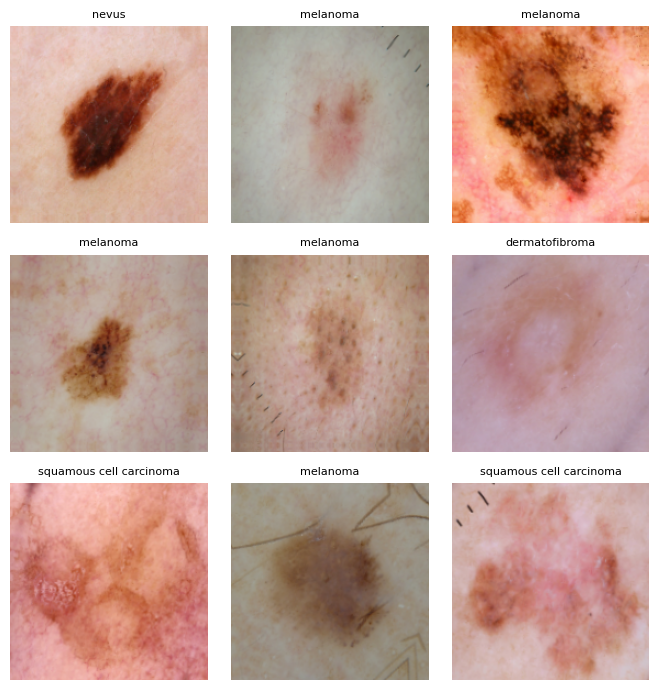

In [40]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=8)  # Adjust font size to 8
        plt.axis("off")
        plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

#### Applying model on data_augmentation

In [46]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomRotation, RandomZoom

model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,  # Apply data augmentation
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.30),
    Flatten(),
    Dense(num_classes, activation='softmax')
])


### Compiling the model

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        25632     
                                                      

### Training the model
# My notes --- Code written in the above block

In [49]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


56/56 [==============================] - 37s 640ms/step - loss: 2.0634 - accuracy: 0.2020 - val_loss: 2.0580 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 39s 702ms/step - loss: 2.0252 - accuracy: 0.2003 - val_loss: 2.0422 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 44s 782ms/step - loss: 2.0171 - accuracy: 0.2132 - val_loss: 2.0362 - val_accuracy: 0.1633
Epoch 4/30
56/56 [==============================] - 112s 2s/step - loss: 2.0124 - accuracy: 0.2132 - val_loss: 2.0025 - val_accuracy: 0.2371
Epoch 5/30
56/56 [==============================] - 94s 2s/step - loss: 2.0419 - accuracy: 0.2227 - val_loss: 2.0080 - val_accuracy: 0.2013
Epoch 6/30
56/56 [==============================] - 40s 720ms/step - loss: 1.9304 - accuracy: 0.2578 - val_loss: 1.8603 - val_accuracy: 0.3423
Epoch 7/30
56/56 [==============================] - 47s 845ms/step - loss: 1.8738 - accuracy: 0.2907 - val_loss: 1.8148 - val_accuracy: 0.2998
Epoch 8/30
56/5

#### If we see here, there is not overfitting now between training dataset accuracy and validation dataset accuracy, ran against 30 epochs

### Visualizing the results

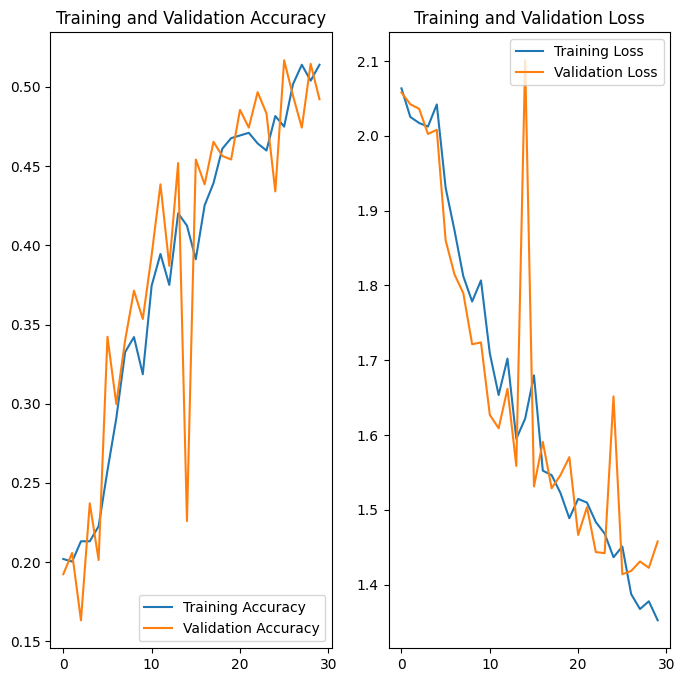

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [52]:
import numpy as np

# Initialize a dictionary to store class counts
class_counts = {}

# Iterate through the training dataset
for images, labels in train_ds:
    # Flatten the labels tensor and convert it to a NumPy array
    labels_array = np.array(labels)
    # Count occurrences of each class label
    unique_labels, counts = np.unique(labels_array, return_counts=True)
    # Update the class counts dictionary
    for label, count in zip(unique_labels, counts):
        if label not in class_counts:
            class_counts[label] = count
        else:
            class_counts[label] += count

# Display the class counts along with class names
for label, count in class_counts.items():
    class_name = class_names[label]
    print(f"{class_name}: {count} samples")

actinic keratosis: 92 samples
basal cell carcinoma: 309 samples
dermatofibroma: 77 samples
melanoma: 352 samples
nevus: 277 samples
pigmented benign keratosis: 370 samples
seborrheic keratosis: 58 samples
squamous cell carcinoma: 142 samples
vascular lesion: 115 samples


### My Notes
##### 1. Which class has the least number of samples? **seborrheic keratosis (58 samples)**
##### 2. Which classes dominate the data in terms proportionate number of samples? **pigmented benign keratosis (370 samples)**
